# Pytorch face detection for ML

*Lionnus Kesting (ETHZ)*

Import packages

In [131]:
# Start with the basics
import numpy as np
from pandas import DataFrame
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Library for plotting
import matplotlib.pyplot as plt

# pytorch
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.io import read_image


# Import library for opening .mat files
import scipy.io

# Import ai8x specifics
#import ai8x

In [132]:
#@title Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: %s' % device)

Device: cuda


## Define dataset class

In [133]:
class WIDERFacesDataset(Dataset):
    def __init__(self, data_path, types, transform=None):
        self.data_path = data_path
        self.annotation_file = os.path.join(self.data_path, 'wider_face_bbx_gt.txt')
        self.transform = transform
        self.types = types
        
        # Load data and annotations
        self.data = self.load_data()
        self.annotations = self.load_annotations()
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.data_path, self.annotations[idx]['image'])
        image = self.load_image(image_path)
        
        bboxes = self.annotations[idx]['bboxes']
        labels = self.annotations[idx]['labels']
        
        if self.transform:
            image, bboxes, labels = self.transform(image, bboxes, labels)
            
        return image, bboxes, labels
    
    def load_data(self):
        data = []
        
        image_files = os.listdir(self.data_path)
        for image_file in image_files:
            if image_file.endswith('.jpg') or image_file.endswith('.png'):
                # Check if the filename starts with an integer contained in the 'types' dictionary
                if int(image_file.split("--")[0]) in self.types:
                    image_file_path = os.path.join(self.data_path, image_file)
                    data.append(image_file_path)
        return data
    
    def load_annotations(self):
        annotations = []

        with open(self.annotation_file, 'r') as f:
            lines = f.read().splitlines()

        i = 0
        while i < len(lines):
            if lines[i].endswith('.jpg') or lines[i].endswith('.png'):
                if int(lines[i].split("--")[0]) in self.types:
                    image_name = lines[i]
                    i += 1
                    num_bboxes = int(lines[i])
                    i += 1

                    bboxes = []
                    labels = []

                    # Iterate over the lines containing the boundary box coordinates
                    for j in range(num_bboxes):
                        bbox_data = lines[i].split(' ')
                        bbox = [
                            int(bbox_data[0]),
                            int(bbox_data[1]),
                            int(bbox_data[2]),
                            int(bbox_data[3])
                        ]
                        bboxes.append(bbox)
                        i += 1
                    # Gather all the labels of the current image
                    label = {
                        'name': image_name.split('/')[1],
                        'faces': num_bboxes,
                        'type': int(image_name.split("--")[0]),
                        'blur': int(bbox_data[4]),
                        'expression': int(bbox_data[5]),
                        'illumination': int(bbox_data[6]),
                        'invalid': int(bbox_data[7]),
                        'occlusion': int(bbox_data[8]),
                        'pose': int(bbox_data[9])
                    }
                    annotation = {
                        'image': image_name,
                        'bboxes': bboxes,
                        'labels': label
                    }
                    annotations.append(annotation)
                else: i=i+int(lines[i+1]) # skip to next image
            i += 1
        return annotations
    
    def load_image(self, path):
        # Load and preprocess the image
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # TODO: Add additional processes below 
        
        return image

#### Test dataset class

Image shape: (714, 1024, 3)
Bounding boxes: [[192, 360, 120, 136], [322, 358, 116, 142], [488, 374, 120, 162], [644, 260, 104, 132]]
Labels: {'name': '7_Cheering_Cheering_7_460.jpg', 'faces': 4, 'type': 7, 'blur': 0, 'expression': 0, 'illumination': 0, 'invalid': 0, 'occlusion': 0, 'pose': 0}


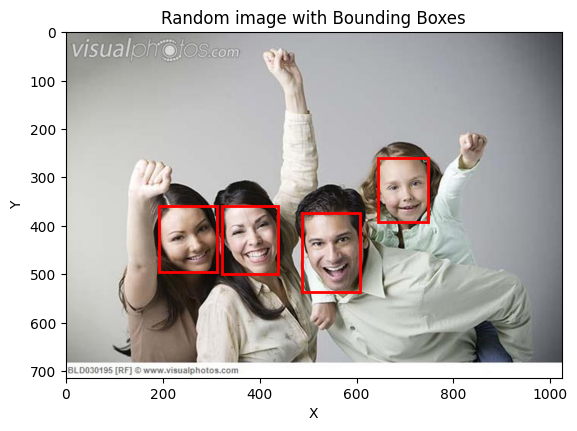

In [137]:
# Instantiate the dataset
data_path = 'WIDER_faces/train'
#annotation_file = 'wider_face_split/wider_face_train_bbx_gt.txt'
dataset = WIDERFacesDataset(data_path, {6,7})

# Test a specific sample
sample = dataset[99]
image, bboxes, labels = sample

# Inspect the sample
print("Image shape:", image.shape)
print("Bounding boxes:", bboxes)
print("Labels:", labels)

# Apply transformations if needed
#transformed_sample = dataset.transform(image, bboxes, labels)
#transformed_image, transformed_bboxes, transformed_labels = transformed_sample

# Test data loading using DataLoader
batch_size = 4
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
fixed_size= (128,128)

# # Iterate over the dataloader
# for batch in dataloader:
#     images, batch_bboxes, batch_labels = batch
#     #resized_images = torch.nn.functional.interpolate(images, size=fixed_size, mode='bilinear', align_corners=False)

#     print("Batch images shape:", images.shape)
#     print("Batch bounding boxes:", batch_bboxes)
#     print("Batch labels:", batch_labels)
#     break  # Stop after the first batch

# Create a figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(image)

# Add bounding boxes to the plot
for bbox in bboxes:
    x, y, w, h = bbox
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# Set axis labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Random image with Bounding Boxes')

# Show the plot
plt.show()

## Define dataloaders

In [140]:

"""
Dataloader function
"""
def WIDER_faces_get_datasets(data, load_train=False, load_test=False, transforms=None):
   
    (data_dir, args) = data
    # data_dir = data

    if load_train:
        train_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomAffine(degrees=30, translate=(0.5, 0.5), scale=(0.5,1.5), fill=0),
            
            transforms.Resize((64,64)),
            transforms.ToTensor()#,
            #ai8x.normalize()
        ])

        train_dataset = WIDERFacesDataset(data_dir=os.path.join(data_dir, "WIDER_faces", "train"), transform=train_transform)
    else:
        train_dataset = None

    if load_test:
        test_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((64,64)),
            transforms.ToTensor()#,
            #ai8x.normalize()
        ])
        # Load validation dataset instead of test dataset, since test dataset is unlabeled
        test_dataset = WIDERFacesDataset(img_dir=os.path.join(data_dir, "WIDER_faces", "val"), transform=test_transform)
    else:
        test_dataset = None

    return train_dataset, test_dataset

#### Test dataloader class

In [142]:
# Example usage
data_path = 'WIDER_faces'
args = {
    'min': 0,   # Minimum value for the range
    'max': 1    # Maximum value for the range
}

data = (data_path,args)
train_dataset, test_dataset = WIDER_faces_get_datasets(data,load_train=True, load_test=True)

# Create the data loaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

AttributeError: 'NoneType' object has no attribute 'Compose'

#### Dataset description

In [87]:
"""
Dataset description
"""
datasets = [
    {
        'name': 'WIDER_faces',
        'input': (3, None, None),  # Variable input size
        'output': list(map(str, range(4))),
        'loader': WIDER_faces_get_datasets,
    }
]

## Define the model

In [112]:
class WIDERFaceNet(nn.Module):
    def __init__(self, num_classes=10, dimensions=(28, 28), num_channels=1, bias=False, **kwargs):
        super().__init__()

        dim_x, dim_y = dimensions

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=num_channels, out_channels=96, kernel_size=11, stride=4, padding=0, bias=bias),
            nn.ReLU(inplace=True)
        )
        dim_x = ((dim_x - 11) // 4) + 1
        dim_y = ((dim_y - 11) // 4) + 1

        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        dim_x = ((dim_x - 3) // 2) + 1
        dim_y = ((dim_y - 3) // 2) + 1

        self.lrn1 = nn.LocalResponseNorm(5)

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=2, padding=1, bias=bias),
            nn.ReLU(inplace=True)
        )

        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        dim_x = ((dim_x - 3) // 2) + 1
        dim_y = ((dim_y - 3) // 2) + 1

        self.lrn2 = nn.LocalResponseNorm(5)

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1, bias=bias),
            nn.ReLU(inplace=True)
        )
        # padding 1 -> no change in dimensions

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1, bias=bias),
            nn.ReLU(inplace=True)
        )
        # padding 1 -> no change in dimensions

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1, bias=bias),
            nn.ReLU(inplace=True)
        )
        # padding 1 -> no change in dimensions

        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=2)
        dim_x = ((dim_x - 3) // 2) + 1
        dim_y = ((dim_y - 3) // 2) + 1

        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=4, padding=0, bias=bias),
            nn.ReLU(inplace=True)
        )
        dim_x = ((dim_x - 4) // 1) + 1
        dim_y = ((dim_y - 4) // 1) + 1

        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=4096, kernel_size=1, padding=0, bias=bias),
            nn.ReLU(inplace=True)
        )
        dim_x = ((dim_x - 1) // 1) + 1
        dim_y = ((dim_y - 1) // 1) + 1

        # Fully connected layer?
        self.fcx = nn.Linear(dim_x * dim_y * 96, num_classes, bias=True)

        # Initialize weights with normal distribution
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    """
    Assemble the model
    """
    def forward(self, x):  # pylint: disable=arguments-differ
            """Forward prop"""
            x = self.conv1(x)
            x = self.pool1(x)
            x = self.lrn1(x)
            x = self.conv2(x)
            x = self.pool2(x)
            x = self.lrn2(x)
            x = self.conv3(x)
            x = self.conv4(x)
            x = self.conv5(x)
            x = self.pool5(x)
            x = self.conv6(x)
            x = self.conv7(x)
            x = x.view(x.size(0), -1)
            x = self.fcx(x)

            return x

def WIDERFaceNet(pretrained=False, **kwargs):
    """
    Constructs a WIDERFaceNet model.
    """
    assert not pretrained
    return WIDERFaceNet(**kwargs)

"""
Network description
"""
models = [
    {
        'name': 'WIDERFaceNet',
        'min_input': 1,
        'dim': 2,
    }
]



Then we define a function for validation.

In [113]:
#@title Define Metrics and validation function
# convenience class to keep track of averages
class Metric(object):
    def __init__(self, name):
        self.name = name
        self.sum  = 0
        self.n    = 0
    def update(self, value):
        self.sum += value
        self.n += 1
    @property
    def avg(self):
        return self.sum / self.n


def validate(model, device, dataloader, verbose=True, integer=False):
    model.eval()
    loss    = 0
    correct = 0
    acc     = Metric('test_acc')
    with tqdm(
        total=len(dataloader), desc='Validation', disable=not verbose,
        ) as t:
        with torch.no_grad():
            for data, target in dataloader:
                if integer:      # support for production of
                    data *= 255  # non-negative integer data
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.argmax(dim=1) # get index of largest log-probability
                correct += pred.eq(target).sum().item()
                acc.update(pred.eq(target).float().mean().item())
                t.set_postfix({'acc': acc.avg})
                t.update(1)
    loss /= len(dataloader.dataset)
    return acc.avg